In [ ]:
# **Import needed Libraries**

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # hadie
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on  during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes mcap_trainany helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm  # hadie
from termcolor import colored  # hadie
from builtins import len  # hadie
import datetime  # hadie
from timeit import default_timer as timer  # hadie
import threading  # hadie


2022-12-06 17:37:47.953267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
start_date = datetime.datetime.now()  # hadie
my_start = timer()  # hadie

In [ ]:
# hyperparameters # hadie
WORD_DICT_SIZE = 15000  # hadie
LIMIT_SIZE = False  # hadie
EXAMPLE_NUMBER = 5  # will only work if LIMIT_SIZE is True # hadie
MY_EMBEDDING_DIM = 256  # hadie
UNIT_COUNT = 512  # hadie
MY_OPTIMIZER = tf.keras.optimizers.SGD() #Adam
MY_LOSS_OBJECT = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
EPOCH_COUNT = 10#20
REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN = False
DATASET = "flick30k"  # "mscoco" or "flickr8k" or "flickr30k"
TEST_SET_PROPORTION = 0.2
feature_extraction_model = "xception"  # hadie
split = 1  # 0 for training, 1 for testing

In [ ]:
#Model

In [ ]:
class BahdanauAttention(tf.keras.Model):

  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):

    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):

  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, _ = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# **Yolov4** model

In [ ]:
# Python program for implementation of Quicksort Sort

# This function takes last element as pivot, places
# the pivot element at its correct position in sorted
# array, and places all smaller (smaller than pivot)
# to left of pivot and all greater elements to right
# of pivot


def partition(arr, low, high):
	i = (low - 1)  # index of smaller element
	pivot = arr[high]  # pivot

	for j in range(low, high):

		# If current element is smaller than or
		# equal to pivot
		if arr[j][6] >= pivot[6]:  # the width of the box times the height of the box times the confidence rate # hadie

			# increment index of smaller element
			i = i + 1
			arr[i], arr[j] = arr[j], arr[i]

	arr[i + 1], arr[high] = arr[high], arr[i + 1]
	return (i + 1)


def quickSort(arr, low, high):
	if len(arr) == 1:
		return arr
	if low < high:

		# pi is partitioning index, arr[p] is now
		# at right place
		pi = partition(arr, low, high)

		# Separately sort elements before
		# partition and after partition
		quickSort(arr, low, pi - 1)
		quickSort(arr, pi + 1, high)


In [ ]:
from yolov4.tf import YOLOv4
import cv2
import time
#from quicksort import quickSort
import numpy as np
import tensorflow as tf

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [ ]:
yolo = YOLOv4()
# yolo = YOLOv4(tiny=True)

yolo.config.parse_names("/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/coco.names")
yolo.config.parse_cfg("/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/yolov4.cfg") #/home/cse-p07-2086-02/Desktop/Nermien Project/DataSets/yolov4.cfg
# yolo.input_size = (480,640)
yolo.make_model()
# yolov4 make model returns error
yolo.load_weights("/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/yolov4.weights", weights_type="yolo")


2022-12-06 17:38:04.882940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:38:08.277343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15301 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:65:00.0, compute capability: 6.1


In [ ]:
# the output is sorted according to the area by confidence
def image_path_to_yolo_bounding_boxes(image_path):  # , coco_dict, word_index):
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    bboxes = yolo.predict(frame, prob_thresh=0.25)
    bboxes = bboxes.tolist()
    n = len(bboxes)
    # for each bounding box, append (area * confidence)
    for i in range(n):
        bboxes[i].append(bboxes[i][2] * bboxes[i][3] * bboxes[i][5])
    quickSort(bboxes, 0, n - 1)
    bboxes = np.array(bboxes)
    return bboxes

In [ ]:

# raw feature extraction - not bounding boxes
def yolo_load_image(image_path):
    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # height, width, _ = frame.shape
    frame = yolo.resize_image(frame)
    frame = frame / 255.0
    frame = frame[np.newaxis, ...].astype(np.float32)
    return frame


In [ ]:
# **Preprocess dataset**

In [ ]:
#A. Download Images and Captions

In [ ]:
if not os.path.exists("trained_model_" + feature_extraction_model):  # create the dicrectory if it does not exists # hadie
    os.makedirs("trained_model_" + feature_extraction_model)  # hadie

#if DATASET == "flickr30k":  # hadie
    # Download caption annotation files
#annotation_folder = '/home/nermien/Downloads/annotations'
    #if not os.path.exists(os.path.abspath('.') + annotation_folder): #is the file exits?
     # annotation_zip = tf.keras.utils.get_file('captions.zip',
                                              #cache_subdir=os.path.abspath('.'),
                                              #origin='http://localhost:8080/annotations_flickr30k.zip',  # we need to chnage this to our host
                                              #extract=True)
      #if split == 0:
       #   annotation_file = os.path.dirname(annotation_zip) + '/annotations_flickr30k/flickr30k_trainval_in_mscoco_format.json'
     # else:
       #   annotation_file = os.path.dirname(annotation_zip) + '/annotations_flickr30k/flickr30k_testing_in_mscoco_format.json'
      #os.remove(annotation_zip)
    #else:
      #if split == 0:
annotation_file1 = '/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/dic_flickr30k.json'

annotation_file2 = '/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/cap_flickr30k.json'
      #else:
          #annotation_file = 'annotations_flickr30k/flickr30k_testing_in_mscoco_format.json'

    # Download image files
image_folder ='/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images'
    #if not os.path.exists(os.path.abspath('.') + image_folder):
      #image_zip = tf.keras.utils.get_file('flickr30k.zip',
                                          #cache_subdir=os.path.abspath('.'),
                                          #origin='http://localhost:8080/flickr30k.zip',  # hadie
                                          #extract=True)
      #PATH = os.path.dirname(image_zip) + image_folder
      #os.remove(image_zip)
    #else:
PATH = image_folder

#else:  # to handle uf the dataset is not found
    #print("Unknow dataset: " + DATASET)  # hadie
    #exit()  # hadie

"""## Optional: limit the size of the training set
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.
"""

"## Optional: limit the size of the training set \nTo speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.\n"

In [ ]:
from itertools import zip_longest

In [ ]:
# Read the json file
with open(annotation_file1, 'r') as f1:
    annotation = json.load(f1)

with open(annotation_file2, 'r') as f2:
    captions = json.load(f2)


# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []
all_ids = []  # hadie

# create an image index # hadie
image_id_index = {}
#for img in annotation['images']:
#image_id_index[img['id']] = img['file_path']

i = 0
for img in annotation['images']:
    image_id_index[img['id']] = img['file_path']
    for i in range (5):
        image_id = img['id']
        all_ids.append(image_id)
        full_flicker30k_image_path = PATH + "/" + str(image_id) + ".jpg"
        if i < 10:
            print(full_flicker30k_image_path)
            i+=1
        all_img_name_vector.append(full_flicker30k_image_path)


for cap1 in captions:
    for cap2 in cap1:
        caption = '<start> ' + " ".join(cap2["caption"]) + ' <end>'
        all_captions.append(caption)


# Shuffle captions and image_names together
# Set a random state
train_ids, train_captions, img_name_vector = shuffle(all_ids,
                                         all_captions,
                                         all_img_name_vector,
                                         random_state=1)

#I think this optional we can remove it #shahd
# Select the first 30000 captions from the shuffled set
# num_examples = EXAMPLE_NUMBER  # hadie
# if LIMIT_SIZE:  # hadie
#     train_ids = train_ids[:num_examples]
#     train_captions = train_captions[:num_examples]
#     img_name_vector = img_name_vector[:num_examples]

# print("training captions: ", len(train_captions), ", all captions: ", len(all_captions))  # hadie

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4910057495.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4910057495.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4910057495.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4910057495.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4910057495.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/552863655.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/552863655.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/552863655.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/552863655.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/552863655.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/2206960564.jpg
/home/cse-p07-2086-02/Desktop/Nermien-Project/Da

In [ ]:
#C. load image

In [ ]:
import tensorflow as tfcse

attention_features_shape = 100+1


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path


image_model = tf.keras.applications.Xception(include_top=False,
                                                weights='imagenet')

In [ ]:
#D. Preprocess Images Using Inception

In [ ]:
"""## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.
"""

# the load_image function has been moved to a separate file by hadie

import importlib  # hadie
#mod = importlib.import_module("feature_extraction_model_" + feature_extraction_model)  # hadie
#image_model = mod.image_model  # hadie
#load_image = mod.load_image  # hadie
#attention_features_shape = mod.attention_features_shape + 1  # hadie

"""## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.
"""

# the image_model variable has been moved to a separate file by hadie  # I added to this notebook

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

"""## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can:

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`
"""

"## Caching the features extracted from InceptionV3\n\nYou will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \\* 8 \\* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).\n\nPerformance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.\n\nThe caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: \n\n1. install [tqdm](https://github.com/tqdm/tqdm):\n\n    `!pip install tqdm`\n\n2. Import tqdm:\n\n    `from tqdm import tqdm`\n\n3. Change the following line:\n\n    `for img, path in image_dataset:`\n\n    to:\n\n    `for img, path in tqdm(image_dataset):`\n"

In [ ]:
# **Start of execution**

In [ ]:
#**1. Extract Features**

In [ ]:
print("-----------------------------START OF EXECUTION-----------------------------")  # hadie
# Get unique images
encode_train = sorted(set(img_name_vector))
# only get unprocessed images # hadie
encode_train = [x for x in encode_train if not os.path.exists(x + "_" + feature_extraction_model + ".npy")]  # check thissss #removed

features_shape = 2048
print("extracting features (" + str(len(encode_train)) + ") file(s)")  # hadie
if len(encode_train) > 0:  # hadie
  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

  for img, path in tqdm(image_dataset):  # hadie
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")

      yolo_features = image_path_to_yolo_bounding_boxes(path_of_feature)  # hadie
      yolo_features = np.array(yolo_features.flatten())  # hadie
      yolo_features = np.pad(yolo_features, (0, features_shape - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  # hadie
      combined_features = np.vstack((bf.numpy(), yolo_features)).astype(np.float32)  # hadie
      np.save(path_of_feature + "_" + feature_extraction_model, combined_features)  # hadie

print("finished extracting features")  # hadie

-----------------------------START OF EXECUTION-----------------------------
extracting features (0) file(s)
finished extracting features


In [ ]:
# **Preprocess the Captions**


In [ ]:
"""## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.
"""


# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


# Choose the top 5000 words from the vocabulary
top_k = WORD_DICT_SIZE  # hadie

#if not REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:  # hadie
   # print("using the cashed tokenizer")  # hadie
    # loading the tokenizer # hadie
    #with open("trained_model_" + feature_extraction_model + "/tokenizer.pickle", 'rb') as handle:  # hadie
        #tokenizer = pickle.load(handle)  # hadie
#else:  # hadie
print("tokenizing and padding captions")  # hadie
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)  # 777 maybe this line needs removal
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
    # saving the tokenizer to disk # hadie
with open("trained_model_" + feature_extraction_model + "/tokenizer.pickle", 'wb') as handle:  # hadie
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)  # hadie

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

#if not REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:  # hadie
    #file = "trained_model_" + feature_extraction_model + "/max_length.txt"  # hadie
    #with open(file, 'r') as filetoread:  # hadie
       # max_length = int(filetoread.readline())  # hadie
#else:  # hadie
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

file = "trained_model_" + feature_extraction_model + "/max_length.txt"  # hadie
with open(file, 'w') as filetowrite:  # hadie
    filetowrite.write(str(max_length))  # write the maximum length to disk # hadie

print("finished tokenizing and padding captions")  # hadie

tokenizing and padding captions
finished tokenizing and padding captions


In [ ]:
# **Split the Data**

In [ ]:
"""## Split the data into training and testing"""

# Create training and validation sets using an 80-20 split
# if TEST_SET_PROPORTION == 0:
#     image_id_train = train_ids
#     image_id_val = []
#     img_name_train = img_name_vector
#     img_name_val = []
#     cap_train = cap_vector
#     cap_val = []
# elif TEST_SET_PROPORTION == 1:
#     image_id_train = []
#     image_id_val = train_ids
#     img_name_train = []
#     img_name_val = img_name_vector
#     cap_train = []
#     cap_val = cap_vector
#else:
image_id_train, image_id_val, img_name_train, img_name_val, cap_train, cap_val = train_test_split(
                                                                    train_ids,  # hadie
                                                                    img_name_vector,
                                                                    cap_vector,
                                                                    test_size= TEST_SET_PROPORTION,  # hadie
                                                                    random_state=0)

print("len(img_name_train) = ", len(img_name_train), ", len(cap_train) = ", len(cap_train), ", len(img_name_val) = ", len(img_name_val), ", len(cap_val) = ", len(cap_val))  # hadie

"""## Create a tf.data dataset for training

Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.
"""

len(img_name_train) =  127132 , len(cap_train) =  127132 , len(img_name_val) =  31783 , len(cap_val) =  31783


"## Create a tf.data dataset for training\n\nOur images and captions are ready! Next, let's create a tf.data dataset to use for training our model.\n"

In [ ]:
# **Data Augmentation**

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import img_to_array
# from tensorflow.keras.utils import array_to_img
# from tensorflow.keras.utils import load_img

In [ ]:
# #First, we need to make everything unique -> so we generate 20% of the orginal and avoid duplicates in augmentation
# img_name_train_np = np.array(img_name_train)
# img_name_train_unq = np.unique(img_name_train_np) #unique paths

# train_ids_np = np.array(train_ids)
# train_ids_unq = np.unique(train_ids_np) #unique ids

In [ ]:
#img_name_train = original data vector carrying all the paths of the images repeated 5 times
#train_ids = original data vector carrying all the ids of the images repeated 5 times
#train_paths_20 = Augumented data vector carrying all the paths of the images repeated 5 times
#train_ids_np_20 = Augumented data vector carrying all the ids of the images repeated 5 times

In [ ]:
# #slice path array to take only first 5000 of the images -> will genrate only 1000
# train_paths_20 = img_name_train_np[0:5000]
# train_id_20 = train_ids_np[0:5000]

In [ ]:
# #percentage - do one augmentation - np.connactate ll array #conactatnion
# #Caption
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90)
# j = 0
# Data_type = object
# for name in train_paths_20: #this vector is supposed to have all the image paths
#   img = load_img(name) #load image by image from the training dataset
#   x = img_to_array(img, dtype= Data_type) #turn the image to a numpy array with shape (3, 150, 150)
#   #print('here')
#   x = x.reshape((1,)+x.shape)
#   #print('reshape')
#   i = 0
#   prefix_str = str(train_id_20[j]) #make the prefix of each image the id, so we can match it later with the
#   j += 1
#   for batch in datagen.flow(x, batch_size=1, save_to_dir='/home/cse-p07-2086-02/Desktop/Nermien-Project/test_aug',  save_prefix= prefix_str, save_format='jpg') :#still need a prefix for the images save #is batch size enough?? #chaneg direcotry #save_to_dir='/preview',  save_prefix= prefix_str, save_format='jpg'
#     i += 1
#     #print('not_here')
#     if i >= 1: #so it will genrate 5 different image form each image we have
#       break

In [ ]:
# import glob
# aug_img_paths = sorted(glob.glob("/home/cse-p07-2086-02/Desktop/Nermien-Project/augmented_data/*"), key=os.path.getmtime)
# print (aug_img_paths[0])

In [ ]:
# import re
# new_id = []
# for path in aug_img_paths:
#     text = path
#     m = re.search('augmented_data/(.+?).jpg', text)
#     if m:
#         new_id.append(m.group(1))
# print(new_id)

In [ ]:
# #CHECK THE LOAD HERE
# path = "/home/cse-p07-2086-02/Desktop/Nermien-Project/augmented_data/"
# Data_type = object
# j=0
# for name in aug_img_paths: #this vector is supposed to have all the image paths
#     img = load_img(name) #load image by image from the training dataset
#     x = img_to_array(img, dtype= Data_type) #turn the image to a numpy array with shape (3, 150, 150)
#     x = x.reshape((1,)+x.shape)
#     i = 0
#     #prefix_str = str(train_id_20[j]) #make the prefix of each image the id, so we can match it later with the
#     np.save(path+new_id[j]+".jpg_xception.npy", x)
#     j += 1

In [ ]:
# # Saving in npy format
# path = "/home/cse-p07-2086-02/Desktop/Nermien-Project/augmented_data/"
# Data_type = object
# j=0
# for name in aug_img_paths: #this vector is supposed to have all the image paths
#     img = load_img(name) #load image by image from the training dataset
#     x = img_to_array(img, dtype= Data_type) #turn the image to a numpy array with shape (3, 150, 150)
#     x = x.reshape((1,)+x.shape)
#     i = 0
#     #prefix_str = str(train_id_20[j]) #make the prefix of each image the id, so we can match it later with the
#     np.save(path+new_id[j]+".jpg_xception.npy", x)
#     j += 1

In [ ]:
#img_name_train = img_name_train + aug_img_paths #give to the orginal variable so I don't hav eo chnage in the rest of the code

In [ ]:
# train_id_20_list=[]
# for item in train_id_20:
#     train_id_20_list.append(item)

In [ ]:
#image_id_train = image_id_train + train_id_20_list#give to the orginal variable so I don't hav eo chnage in the rest of the code

In [ ]:
# train_cap_vec = cap_train[0:5000]

In [ ]:
#cap_train = list(cap_train) + list(train_cap_vec)

In [ ]:
#Done with augmentation

In [ ]:
BATCH_SIZE = 32  # 64np.save( filename + '.npy', data)

BUFFER_SIZE = 1000  # 10000
embedding_dim = MY_EMBEDDING_DIM  # hadie'/home/cse-p07-2086-02/Desktop/Nermien-Project/augmented_data/353913_0_4127.jpg'

units = UNIT_COUNT  # hadie
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# the definition of features_shape = 2048 was moved up
# the attention_features variable has been moved to a separate file by hadie

# Load the numpy files
count =0
def map_func(img_name, cap):
    global count
    img_tensor = np.load(img_name.decode('utf-8') + "_" + feature_extraction_model + '.npy') #check thissss
  #print()
    count += 1
    return img_tensor, cap #chahgnbed img_tensor here to img_name

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel

dataset = dataset.map(lambda item1, item2: tf.numpy_function( #comment thissss
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# dataset

In [ ]:
# **Remainng of the Model**

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
img_name_train
optimizer = MY_OPTIMIZER  # hadie
loss_object = MY_LOSS_OBJECT  # hadie


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [ ]:
# **Check points**

In [ ]:
checkpoint_path = "./checkpoints/train"
# hadie
if REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:
    try:
        for filename in os.listdir(checkpoint_path):
            print("deleting " + checkpoint_path + "/" + filename)
            os.unlink(checkpoint_path + "/" + filename)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (checkpoint_path + "/" + filename, e))
    # remove the saved model too
    if os.path.exists("./trained_model_" + feature_extraction_model + "/my_model.index"):
        print("deleting trained_model_" + feature_extraction_model + "/my_model.index")
        os.unlink("./trained_model_" + feature_extraction_model + "/my_model.index")
    if os.path.exists("./trained_model_" + feature_extraction_model + "/checkpoint"):
        print("deleting /trained_model_" + feature_extraction_model + "/checkpoint")
        os.unlink("./trained_model_" + feature_extraction_model + "/checkpoint")
    if os.path.exists("./trained_model_" + feature_extraction_model + "/my_model.data-00000-of-00001"):
        print("deleting trained_model_" + feature_extraction_model + "/my_model.data-00000-of-00001")
        os.unlink("./trained_model_" + feature_extraction_model + "/my_model.data-00000-of-00001")
    if os.path.exists("./trained_model_" + feature_extraction_model + "/learning_curve.png"):
        print("deleting trained_model_" + feature_extraction_model + "/learning_curve.png")
        os.unlink("./trained_model_" + feature_extraction_model + "/learning_curve.png")

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# **Training**

In [ ]:
"""## Training
* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.
"""

# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = EPOCH_COUNT  # hadie

if not os.path.exists("trained_model_" + feature_extraction_model + "/my_model.index"):  # hadie
    print("training..")  # hadie img_name_train
    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)

            total_loss += t_loss

            if batch % 100 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if epoch % 5 == 0:
            ckpt_manager.save()

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss / num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    # save model to disk # hadie
    decoder.save_weights("trained_model_" + feature_extraction_model + "/my_model" , save_format="tf")  # hadie
else:  # hadie
    print("A trained model has been found. Loading it from disk..")  # hadie
    # Load the previously saved weights # hadie
    decoder.load_weights("trained_model_" + feature_extraction_model + "/my_model")  # hadie

training..


2022-12-06 17:38:40.041622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 487 of 1000
2022-12-06 17:38:50.071048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 992 of 1000
2022-12-06 17:38:50.131858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-12-06 17:40:01.663888: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


Epoch 3 Batch 0 Loss 0.6301
Epoch 3 Batch 100 Loss 0.5129
Epoch 3 Batch 200 Loss 0.6419
Epoch 3 Batch 300 Loss 0.6585
Epoch 3 Batch 400 Loss 0.5907
Epoch 3 Batch 500 Loss 0.5797
Epoch 3 Batch 600 Loss 0.6135
Epoch 3 Batch 700 Loss 0.5604
Epoch 3 Batch 800 Loss 0.5700
Epoch 3 Batch 900 Loss 0.5046
Epoch 3 Batch 1000 Loss 0.4961
Epoch 3 Batch 1100 Loss 0.5615
Epoch 3 Batch 1200 Loss 0.5379
Epoch 3 Batch 1300 Loss 0.5798
Epoch 3 Batch 1400 Loss 0.6692
Epoch 3 Batch 1500 Loss 0.5539
Epoch 3 Batch 1600 Loss 0.6172
Epoch 3 Batch 1700 Loss 0.5803
Epoch 3 Batch 1800 Loss 0.6580
Epoch 3 Batch 1900 Loss 0.5929
Epoch 3 Batch 2000 Loss 0.5570
Epoch 3 Batch 2100 Loss 0.5636
Epoch 3 Batch 2200 Loss 0.5135
Epoch 3 Batch 2300 Loss 0.5437
Epoch 3 Batch 2400 Loss 0.5940
Epoch 3 Batch 2500 Loss 0.6993
Epoch 3 Batch 2600 Loss 0.4827
Epoch 3 Batch 2700 Loss 0.6463
Epoch 3 Batch 2800 Loss 0.5554
Epoch 3 Batch 2900 Loss 0.6043
Epoch 3 Batch 3000 Loss 0.6942
Epoch 3 Batch 3100 Loss 0.5112
Epoch 3 Batch 3200 L

In [ ]:
# plot the results

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape)) #n
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    yolo_features = image_path_to_yolo_bounding_boxes(image.decode("utf-8"))
    yolo_features = np.array(yolo_features.flatten())  # hadie
    yolo_features = np.pad(yolo_features, (0, features_shape - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)  # hadie
    combined_features = np.vstack((img_tensor_val[0].numpy(), yolo_features)).astype(np.float32)  # hadie
    features = encoder(combined_features)  # hadie

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result),:]
    return result, attention_plot


In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()
# captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)
#
# print ('Real Caption:', real_caption)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

# image = "C:/Users/Hadie/Downloads/download.jpg"  # hadie
# result, attention_plot = evaluate(image)  # hadie

# print ('Prediction Caption:`', ' '.join(result))  # hadie
# plot_attention(image, result, attention_plot)  # hadie

In [ ]:
"""## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)
"""

# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image' + image_extension,
#                                     origin=image_url)

# in the future, prediction of a single image will be moved to a separate 00 Loss 0.5280
Epoch 10 Batch 2700 Loss 0.6053
Epoch 10 Batch 2800 Loss 0.5514
Epoch 10 Batch 2900 Loss 0.5233
Epoch 10 Batch 3000 Loss 0.5761
Epoch 10 Batch 3100 Loss 0.5256
Epoch 10 Batch 3200 Loss 0.4423
Epoch 10 Batch 3300 Loss 0.4737
Epoch 10 Batch 3400 Loss 0.4652
Epoch 10 Batch 3500 Loss 0.4749
Epoch 10 Batch 3600 Loss 0.4634
Epoch 10 Batch 3700 Loss 0.5206
Epoch 10 Batch 3800 Loss 0.5141
Epoch 10 Batch 3900 Loss 0.4669
Epoch 10 Loss 0.517646
Time taken for 1 epoch 1091.0452466011047 secfile
# result, attention_plot = evaluate(image_path)  # hadie
# print ('Prediction Caption:', ' '.join(result))  # hadie
# plot_attention(image_path, result, attention_plot) # hadie
# opening the image # hadie
# Image.open(image_path) # hadie

# validation, this whole section was written by hadie # hadie

def validate_image(id, image_name_for_validation, original_caption):
    print("Evaluating:", image_name_for_validation.decode("utf-8"), "From thread", threading.current_thread().ident)

    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis
    result = ' '.join(result).replace("<end>", "").strip()  # remove unnecessary characters

    dict = {}
    dict["image_id"] = int(id)  # .decode("utf-8")
    dict["caption"] = result;
    dict["original_caption"] = original_caption.decode("utf-8")
    dict["file_name"] = image_name_for_validation.decode("utf-8")
    return json.dumps(dict)
caption_strings_val = list(map(lambda item: (' '.join([tokenizer.index_word[i] for i in item if i not in [0]])).replace("<end>", "").replace("<start>", "").strip(), cap_val))  # convert to a list of strings
validation_dataset = tf.data.Dataset.from_tensor_slices((image_id_val, img_name_val, caption_strings_val))  # create the dataset
eval_start_date = datetime.datetime.now()  # hadie
list_of_dicts = validation_dataset.map(lambda item1, item2, item3: tf.numpy_function(validate_image, [item1, item2, item3], [tf.string]), num_parallel_calls=1)  # run in parallel
list_of_dicts = list(list_of_dicts.as_numpy_iterator())  # convert to a list
list_of_dicts = [item for sublist in list_of_dicts for item in sublist]  # flatten the list by removing nested tuples
list_of_dicts = list(map(lambda item: json.loads(item), list_of_dicts))  # rewrap the strings as dictionaries, then convert to a list

# eliminate duplicate id entries because the evaluation code does not allow them
added_ids = []
unique_list_of_dicts = []
for dict in list_of_dicts:
    if not dict["image_id"] in added_ids:
        added_ids.append(dict["image_id"])
        unique_list_of_dicts.append(dict)

file = "trained_model_" + feature_extraction_model + "/results.json"  # hadie
with open(file, 'w') as filetowrite:  # hadie
    filetowrite.write(json.dumps(unique_list_of_dicts))  # hadie

print("The results have been written to trained_model_" + feature_extraction_model + "/results.json")  # hadie
print("Main thread:", threading.current_thread().ident)  # hadie

end_date = datetime.datetime.now()  # hadie

my_end = timer()  # hadie
hours, rem = divmod(my_end - my_start, 3600)  # hadie
minutes, seconds = divmod(rem, 60)  # hadie

print("Start time: " + str(start_date))  # hadie
print("Evaluation start time: " + str(eval_start_date))  # hadie
print("End time: " + str(end_date))  # hadie

print("Time elapsed (hours:minutes:seconds): {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))  # hadie

#if REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:  # hadie
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
#plt.savefig("trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
plt.show() # hadie

print("The learning curve has been written to trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
print("Feature extraction model: " + feature_extraction_model)
print("Dataset: " + DATASET)
print("Development set proportion: " + str(TEST_SET_PROPORTION))
print("with yolo bounding boxes")

"""# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.
"""

Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/2975627633.jpg From thread 139710680770304
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3384314832.jpg From thread 139710689163008
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4604969760.jpg From thread 139710689163008
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3584860179.jpg From thread 139710680770304
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4967473493.jpg From thread 139710689163008
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4886237647.jpg From thread 139710680770304
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/2316985974.jpg From thread 139710680770304
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3700346840.jpg From thread 

2022-12-06 20:41:03.849361: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: KeyError: 12078
Traceback (most recent call last):

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_3203/2981694065.py", line 22, in validate_image
    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis

  File "/tmp/ipykernel_3203/3614327557.py", line 24, in evaluate
    result.append(tokenizer.index_word[predicted_id])

KeyError: 12078




UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 12078
Traceback (most recent call last):

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_3203/2981694065.py", line 22, in validate_image
    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis

  File "/tmp/ipykernel_3203/3614327557.py", line 24, in evaluate
    result.append(tokenizer.index_word[predicted_id])

KeyError: 12078


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [ ]:
"""## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)
"""

# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image' + image_extension,
#                                     origin=image_url)

# in the future, prediction of a single image will be moved to a separate file
# result, attention_plot = evaluate(image_path)  # hadie
# print ('Prediction Caption:', ' '.join(result))  # hadie
# plot_attention(image_path, result, attention_plot) # hadie
# opening the image # hadie
# Image.open(image_path) # hadie

# validation, this whole section was written by hadie # hadie

def validate_image(id, image_name_for_validation, original_caption):
    print("Evaluating:", image_name_for_validation.decode("utf-8"), "From thread", threading.current_thread().ident)

    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis
    result = ' '.join(result).replace("<end>", "").strip()  # remove unnecessary characters

    dict = {}
    dict["image_id"] = int(id)  # .decode("utf-8")
    dict["caption"] = result;
    dict["original_caption"] = original_caption.decode("utf-8")
    dict["file_name"] = image_name_for_validation.decode("utf-8")
    return json.dumps(dict)
caption_strings_val = list(map(lambda item: (' '.join([tokenizer.index_word[i] for i in item if i not in [0]])).replace("<end>", "").replace("<start>", "").strip(), cap_val))  # convert to a list of strings
validation_dataset = tf.data.Dataset.from_tensor_slices((image_id_val, img_name_val, caption_strings_val))  # create the dataset
eval_start_date = datetime.datetime.now()  # hadie
list_of_dicts = validation_dataset.map(lambda item1, item2, item3: tf.numpy_function(validate_image, [item1, item2, item3], [tf.string]), num_parallel_calls=1)  # run in parallel
list_of_dicts = list(list_of_dicts.as_numpy_iterator())  # convert to a list
list_of_dicts = [item for sublist in list_of_dicts for item in sublist]  # flatten the list by removing nested tuples
list_of_dicts = list(map(lambda item: json.loads(item), list_of_dicts))  # rewrap the strings as dictionaries, then convert to a list

# eliminate duplicate id entries because the evaluation code does not allow them
added_ids = []
unique_list_of_dicts = []
for dict in list_of_dicts:
    if not dict["image_id"] in added_ids:
        added_ids.append(dict["image_id"])
        unique_list_of_dicts.append(dict)

file = "trained_model_" + feature_extraction_model + "/results.json"  # hadie
with open(file, 'w') as filetowrite:  # hadie
    filetowrite.write(json.dumps(unique_list_of_dicts))  # hadie

print("The results have been written to trained_model_" + feature_extraction_model + "/results.json")  # hadie
print("Main thread:", threading.current_thread().ident)  # hadie

end_date = datetime.datetime.now()  # hadie

my_end = timer()  # hadie
hours, rem = divmod(my_end - my_start, 3600)  # hadie
minutes, seconds = divmod(rem, 60)  # hadie

print("Start time: " + str(start_date))  # hadie
print("Evaluation start time: " + str(eval_start_date))  # hadie
print("End time: " + str(end_date))  # hadie

print("Time elapsed (hours:minutes:seconds): {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))  # hadie

#if REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:  # hadie
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
#plt.savefig("trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
plt.show() # hadie

print("The learning curve has been written to trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
print("Feature extraction model: " + feature_extraction_model)
print("Dataset: " + DATASET)
print("Development set proportion: " + str(TEST_SET_PROPORTION))
print("with yolo bounding boxes")

"""# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.
"""

Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/2975627633.jpg From thread 139709766424320
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3384314832.jpg From thread 139710001288960
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4604969760.jpg From thread 139710001288960
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3584860179.jpg From thread 139709766424320
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4967473493.jpg From thread 139710001288960
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/4886237647.jpg From thread 139710001288960
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/2316985974.jpg From thread 139709766424320
Evaluating: /home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3700346840.jpg From thread 

2022-12-06 21:07:50.788707: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: KeyError: 8812
Traceback (most recent call last):

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_3203/2981694065.py", line 22, in validate_image
    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis

  File "/tmp/ipykernel_3203/3614327557.py", line 24, in evaluate
    result.append(tokenizer.index_word[predicted_id])

KeyError: 8812




UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 8812
Traceback (most recent call last):

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/cse-p07-2086-02/anaconda3/envs/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_3203/2981694065.py", line 22, in validate_image
    result, attention_plot = evaluate(image_name_for_validation)  # generate the hypothesis

  File "/tmp/ipykernel_3203/3614327557.py", line 24, in evaluate
    result.append(tokenizer.index_word[predicted_id])

KeyError: 8812


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [ ]:
#before running next cell remove decode from yolo_features

Real Caption: <start> a black dog walks through some water <end>
Prediction Caption: two built of the water <end>


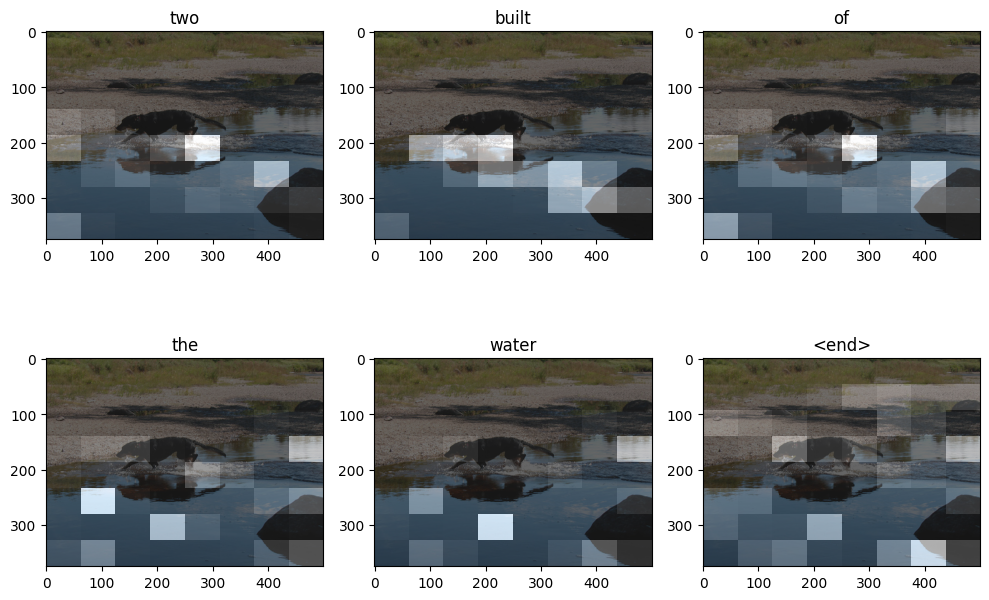

Prediction Caption:` a medium dog catches its mouth standing in grass <end>


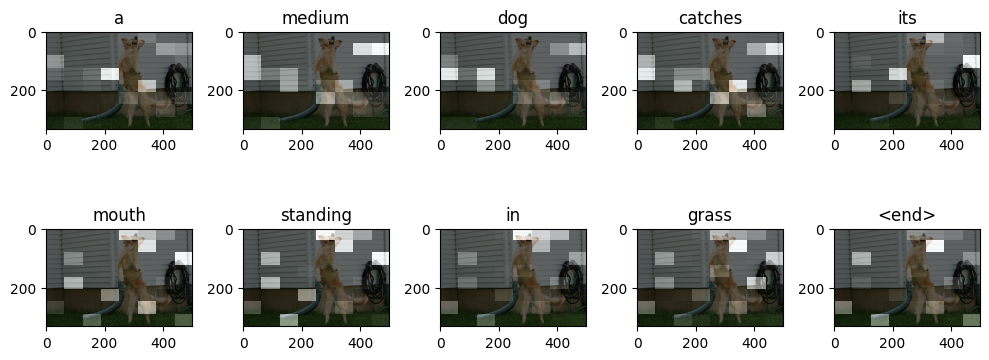

In [ ]:
# #captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print ('Real Caption:', real_caption)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

# image = "/home/cse-p07-2086-02/Desktop/Nermien-Project/DataSets/flickr30k-images/3595643050.jpg"  # hadie
# result, attention_plot = evaluate(image)  # hadie

# print ('Prediction Caption:`', ' '.join(result))  # hadie
# plot_attention(image, result, attention_plot)  # hadie

Prediction Caption: a man on a blue surfboard he float board in the water surfing a water <end>


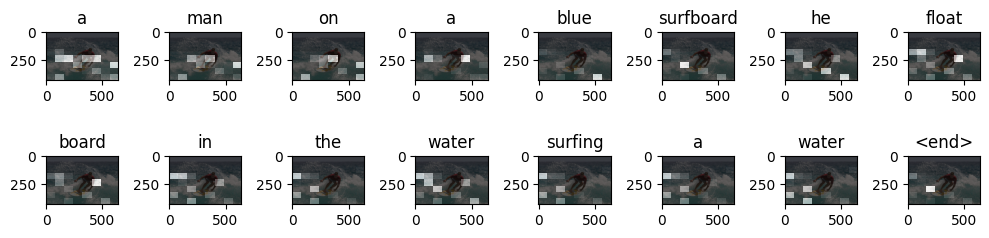

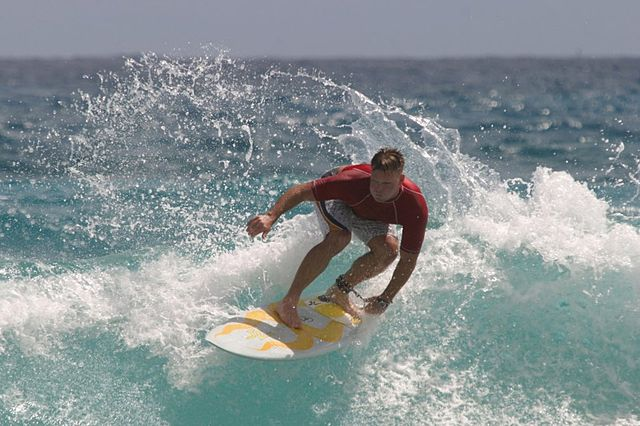

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image' + image_extension,
                                origin=image_url)

# in the future, prediction of a single image will be moved to a separate file
result, attention_plot = evaluate(image_path)  # hadie
print ('Prediction Caption:', ' '.join(result))  # hadie
plot_attention(image_path, result, attention_plot) # hadie
# opening the image # hadie
Image.open(image_path) # hadie

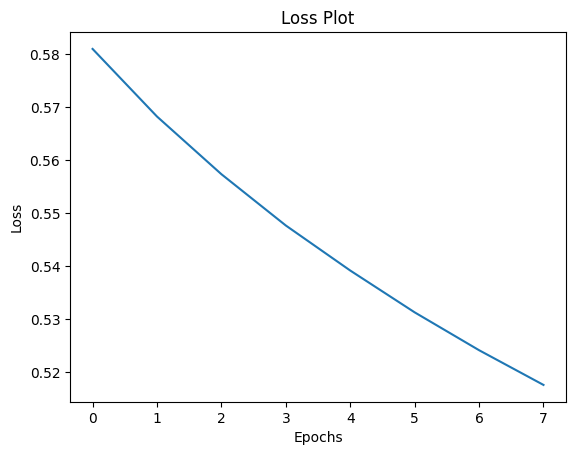

The learning curve has been written to trained_model_xception/learning_curve.png
Feature extraction model: xception
Dataset: flick30k
Development set proportion: 0.2
with yolo bounding boxes


"# Next steps\n\nCongrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.\n"

In [ ]:
#if REMOVE_CHECKPOINTS_AND_MODEL_AND_RETRAIN:  # hadie
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
#plt.savefig("trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
plt.show() # hadie

print("The learning curve has been written to trained_model_" + feature_extraction_model + "/learning_curve.png")  # hadie
print("Feature extraction model: " + feature_extraction_model)
print("Dataset: " + DATASET)
print("Development set proportion: " + str(TEST_SET_PROPORTION))
print("with yolo bounding boxes")

"""# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.
"""